<a href="https://colab.research.google.com/github/jgbrenner/psychometrics/blob/main/C9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Generating Psychometric Scale Items Using an Open Source LLM and Conducting Exploratory Graph Analysis**



# Methodology

# Overview

In this notebook, I will utilize an open-source large language model (LLM) to generate items for a psychometric scale measuring three dimensions of perfectionism: Rigid Perfectionism, Self-Critical Perfectionism, and Narcissistic Perfectionism. Following item generation, I will perform Exploratory Graph Analysis (EGA) to validate the structure and dimensionality of the generated items.


# Steps Involved

Item Generation:
I prompted the LLM to generate six items for each construct, specifying that five should be regular-keyed and one should be reverse-keyed. The output was formatted in JSON for easy processing.
The constructs targeted are:

- Rigid Perfectionism

- Self-Critical Perfectionism

- Narcissistic Perfectionism


# Data Preparation:

The generated items were compiled into a data frame, and constructs were extracted for further analysis.
An embeddings array was created to represent the items in a high-dimensional space suitable for EGA.

# Transfer to R:

The embeddings array and constructs list were transferred from Python to R using the rpy2 interface.

# Exploratory Graph Analysis (EGA):

In R, the embeddings array was converted into a matrix format, with appropriate row names assigned based on the constructs.
The EGAnet library was utilized to perform EGA on the embeddings matrix, allowing for an exploration of the underlying structure of the psychometric items.

Results were printed and visualized to assess the dimensionality of the constructs.

# Conclusion
This methodology enables a systematic approach to generating and validating psychometric scale items, ensuring that they are both relevant and statistically sound.

In [1]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 3.6 MB/s eta 0:00:00


In [2]:
# Load the R magic extension for rpy2
%load_ext rpy2.ipython

import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define the path where the R library will be saved in Google Drive
library_path = '/content/drive/MyDrive/R_libraries'

# Create the directory if it doesn't exist
if not os.path.exists(library_path):
    os.makedirs(library_path)

Mounted at /content/drive


In [3]:
#verify rpy2 version as this is known to cause errors ( ver 3.4.2 works fine )
import rpy2
print(f"rpy2 version: {rpy2.__version__}")

rpy2 version: 3.4.2


In [4]:
%%R -i library_path

# Set the custom library path to persist during the Colab session
.libPaths(library_path)

# Set CRAN repository globally
options(repos = c(CRAN = "https://cloud.r-project.org"))

# List of required R packages
required_packages <- c("gmp", "Rmpfr", "CVXR", "fungible", "EGAnet")

# Install each package only if it's not already installed
for (pkg in required_packages) {
    if (!requireNamespace(pkg, quietly = TRUE)) {
        install.packages(pkg, lib = library_path, dependencies = TRUE)
    }
}

# Load EGAnet library
library(EGAnet)


EGAnet (version 2.1.0) 

For help getting started, see <https://r-ega.net> 

For bugs and errors, submit an issue to <https://github.com/hfgolino/EGAnet/issues>



In [5]:
# Import necessary Python libraries
import openai
import pandas as pd
import numpy as np
import json
import requests
import re


from google.colab import userdata

#fetching the OpenAI API key from secrets
openai_api_key = userdata.get('OPENAI_API_KEY')

from groq import Groq

#fetching the Groq API key from secrets
groq_api_key = userdata.get('GROQ_API_KEY')

# Initialize the Groq client
client = Groq(api_key=groq_api_key)

# Prompting is everything.

 Using the llama3-8b-8192 model  with this particualr prompt I was able to get the results needed. For other models the prompt might need to be modified, as all models are non-deterministic.

In [6]:
# Define the messages for the LLM
messages = [
    {
        "role": "system",
        "content": "You are an expert psychometrician creating test items."
    },
    {
        "role": "user",
        "content": (
            "Please generate six items for each of the following constructs: "
            "Rigid Perfectionism, Self-Critical Perfectionism, and Narcissistic Perfectionism. "
            "For each construct, provide six regular-keyed items "
            "Make them concise and clear. "
            "Provide the output ONLY in JSON format as a list of dictionaries, "
            "without any additional text or explanation. "
            "Each dictionary should have keys 'construct', 'item', and 'type' (either 'regular-keyed' or 'reverse-keyed')."
        )
    }
]

try:
    # Create the completion request
    completion = client.chat.completions.create(
        model="llama3-8b-8192", # using opensource model for replication purposes
        messages=messages,
        temperature=1,
        max_tokens=2048,
        top_p=1,
        stream=False,  # Disable streaming for simplicity
        stop=None,
    )

    # Collect the response content
    response_content = completion.choices[0].message.content
    print("\nLLM Output:\n", response_content)

except Exception as e:
    print(f"An error occurred: {e}")
    response_content = ""



LLM Output:
 [
  {
    "construct": "Rigid Perfectionism",
    "item": "I feel annoyed when others don't meet my expectations",
    "type": "regular-keyed"
  },
  {
    "construct": "Rigid Perfectionism",
    "item": "I am very critical of myself when I make a mistake",
    "type": "regular-keyed"
  },
  {
    "construct": "Rigid Perfectionism",
    "item": "I try to avoid tasks that I'm not sure I can do perfectly",
    "type": "regular-keyed"
  },
  {
    "construct": "Rigid Perfectionism",
    "item": "I feel guilty if I take a break or relax",
    "type": "regular-keyed"
  },
  {
    "construct": "Rigid Perfectionism",
    "item": "I set extremely high standards for myself",
    "type": "regular-keyed"
  },
  {
    "construct": "Rigid Perfectionism",
    "item": "Others expect too much from me",
    "type": "reverse-keyed"
  },
  {
    "construct": "Self-Critical Perfectionism",
    "item": "I am too hard on myself",
    "type": "regular-keyed"
  },
  {
    "construct": "Self-Crit

In [7]:
# Parse the JSON response
try:
    generated_items = json.loads(response_content)
    items_df = pd.DataFrame(generated_items)
except json.JSONDecodeError as e:
    print(f"JSON decoding failed: {e}")
    # Attempt to extract JSON content from the response
    json_match = re.search(r'\[.*\]', response_content, re.DOTALL)
    if json_match:
        json_str = json_match.group(0)
        try:
            generated_items = json.loads(json_str)
            items_df = pd.DataFrame(generated_items)
        except json.JSONDecodeError as e2:
            print(f"Second JSON decoding attempt failed: {e2}")
            items_df = None
    else:
        print("No JSON content found in the response.")
        items_df = None

# Check if items_df is defined
if items_df is not None:
    # Save to CSV (optional)
    items_df.to_csv("perfectionism_items.csv", index=False)
    print("Items saved to 'perfectionism_items.csv'.")

    # Prepare the list of items
    item_texts = items_df["item"].tolist()

    # Ensure item_texts is clean and valid
    item_texts = [item for item in item_texts if item.strip()]  # Filter empty strings

    # Set up the API endpoint and headers for OpenAI embeddings
    embedding_endpoint = "https://api.openai.com/v1/embeddings"
    embedding_model = "text-embedding-3-small"  # Using a commonly available model

    headers = {
        "Authorization": f"Bearer {openai_api_key}",
        "Content-Type": "application/json"
    }

    # Prepare the data payload
    data = {
        "model": embedding_model,
        "input": item_texts
    }

    # Make the API request
    try:
        response = requests.post(embedding_endpoint, headers=headers, json=data)

        # Check if the request was successful
        if response.status_code != 200:
            print(f"Request failed with status code {response.status_code}: {response.text}")
        else:
            response_data = response.json()
            # Extract embeddings
            embeddings = [item['embedding'] for item in response_data['data']]
            embeddings_array = np.array(embeddings)
            print(f"Embeddings generated successfully. Shape: {embeddings_array.shape}")
            # Save the embeddings
            np.save("embeddings.npy", embeddings_array)
            print("Embeddings saved as 'embeddings.npy'.")
    except Exception as e:
        print(f"An error occurred during embedding generation: {e}")
else:
    print("Error: items_df is not defined. Cannot proceed with embedding generation.")



Items saved to 'perfectionism_items.csv'.
Embeddings generated successfully. Shape: (18, 1536)
Embeddings saved as 'embeddings.npy'.


In [32]:
# Prepare constructs list with unique item labels
items_df['item_label'] = items_df.apply(
    lambda row: f"{''.join([word[0] for word in row['construct'].split()])}{row.name+1}", axis=1
)
items_constructs = items_df['item_label'].tolist()


# Transfer data to R
%R -i embeddings_array -i items_constructs

In [33]:
%%R
# Convert embeddings_array to a matrix
embeddings_matrix <- as.matrix(embeddings_array)

# Assign row names to the matrix
rownames(embeddings_matrix) <- items_constructs

# Compute the correlation matrix between items
cor_matrix <- cor(t(embeddings_matrix))



Print correlation matrix heatmap

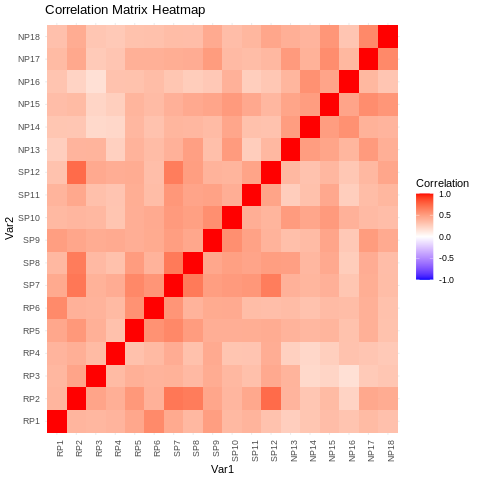

In [34]:
%%R

library(ggplot2)
library(reshape2)

# Melt the correlation matrix for plotting
heatmap_data <- melt(cor_matrix)

# Create a heatmap
ggplot(heatmap_data, aes(Var1, Var2, fill = value)) +
    geom_tile() +
    scale_fill_gradient2(low = "blue", high = "red", mid = "white", limit = c(-1, 1), name="Correlation") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(title = "Correlation Matrix Heatmap")

## **EGA result**

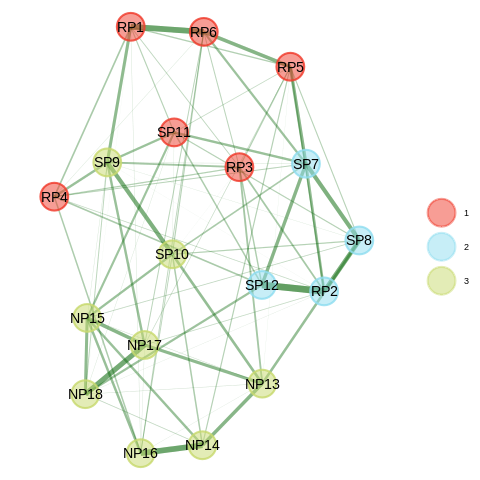

In [38]:
%%R

# Load EGAnet library
library(EGAnet)



# Perform EGA analysis with adjusted parameters
ega_result <- EGA(
    data = cor_matrix,
    n = 1000,                # Set a hypothetical sample size
    corr = "auto",           # Indicate that data is a correlation matrix
    model = "glasso",
    lambda.min.ratio = 0.1,    # Reduce lambda.min.ratio
    args.glasso = list(gamma = 0.1),  # Reduce gamma for sensitivity
    plot.EGA = TRUE,
    verbose = TRUE
)




In [39]:
%%R
print(cor_matrix)

           RP1       RP2       RP3       RP4       RP5       RP6       SP7
RP1  1.0000000 0.3822854 0.3739476 0.3873512 0.4559483 0.5985329 0.4423022
RP2  0.3822854 1.0000000 0.4681422 0.4136239 0.5306660 0.4022685 0.6842259
RP3  0.3739476 0.4681422 1.0000000 0.3553921 0.4096564 0.3956416 0.4013353
RP4  0.3873512 0.4136239 0.3553921 1.0000000 0.3241437 0.3613452 0.4274455
RP5  0.4559483 0.5306660 0.4096564 0.3241437 1.0000000 0.5591554 0.6066232
RP6  0.5985329 0.4022685 0.3956416 0.3613452 0.5591554 1.0000000 0.5444051
SP7  0.4423022 0.6842259 0.4013353 0.4274455 0.6066232 0.5444051 1.0000000
SP8  0.3694171 0.6626703 0.3628016 0.3229238 0.5090874 0.3942816 0.6717341
SP9  0.5007057 0.4606237 0.4315497 0.4395100 0.4185418 0.4370674 0.5005149
SP10 0.3642780 0.3783090 0.3683704 0.3029129 0.4183296 0.4382075 0.5194063
SP11 0.3917190 0.4514931 0.3303610 0.3063885 0.4223005 0.3436532 0.5358975
SP12 0.3156930 0.7351018 0.4443802 0.4243923 0.4318480 0.3386925 0.6572931
NP13 0.2539246 0.3873753 

In [40]:
%%R

# Summary statistics of the correlation matrix
summary(cor_matrix)

      RP1              RP2              RP3              RP4        
 Min.   :0.2539   Min.   :0.2289   Min.   :0.1639   Min.   :0.2087  
 1st Qu.:0.3300   1st Qu.:0.3836   1st Qu.:0.3062   1st Qu.:0.3023  
 Median :0.3717   Median :0.4402   Median :0.3712   Median :0.3235  
 Mean   :0.4148   Mean   :0.4843   Mean   :0.3829   Mean   :0.3706  
 3rd Qu.:0.4297   3rd Qu.:0.5150   3rd Qu.:0.4076   3rd Qu.:0.4071  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
      RP5              RP6              SP7              SP8        
 Min.   :0.3191   Min.   :0.3163   Min.   :0.2989   Min.   :0.2637  
 1st Qu.:0.3878   1st Qu.:0.3454   1st Qu.:0.4038   1st Qu.:0.3708  
 Median :0.4184   Median :0.3950   Median :0.4714   Median :0.4504  
 Mean   :0.4606   Mean   :0.4395   Mean   :0.5137   Mean   :0.4754  
 3rd Qu.:0.4958   3rd Qu.:0.4379   3rd Qu.:0.5911   3rd Qu.:0.4988  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
      SP9              SP10       

In [41]:
%%R

pca_result <- prcomp(cor_matrix, scale. = TRUE)
summary(pca_result)


Importance of components:
                          PC1    PC2    PC3    PC4     PC5     PC6     PC7
Standard deviation     2.1934 1.6871 1.4182 1.3517 1.18373 1.14023 0.94384
Proportion of Variance 0.2673 0.1581 0.1117 0.1015 0.07785 0.07223 0.04949
Cumulative Proportion  0.2673 0.4254 0.5371 0.6386 0.71648 0.78871 0.83820
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.73509 0.69817 0.67164 0.58353 0.55747 0.48604 0.48033
Proportion of Variance 0.03002 0.02708 0.02506 0.01892 0.01727 0.01312 0.01282
Cumulative Proportion  0.86822 0.89530 0.92036 0.93928 0.95655 0.96967 0.98249
                         PC15    PC16    PC17      PC18
Standard deviation     0.3624 0.34384 0.25618 1.444e-16
Proportion of Variance 0.0073 0.00657 0.00365 0.000e+00
Cumulative Proportion  0.9898 0.99635 1.00000 1.000e+00


In [42]:
%%R

high_correlations <- which(abs(cor_matrix) > 0.5 & lower.tri(cor_matrix), arr.ind = TRUE)
high_correlations_df <- as.data.frame(high_correlations)

# Display item pairs with high correlations
print(high_correlations_df)

       row col
RP6      6   1
SP9      9   1
RP5      5   2
SP7      7   2
SP8      8   2
SP12    12   2
RP6.1    6   5
SP7.1    7   5
SP8.1    8   5
SP7.2    7   6
SP8.2    8   7
SP9.1    9   7
SP10    10   7
SP11    11   7
SP12.1  12   7
SP12.2  12   8
SP10.1  10   9
NP17    17   9
NP13    13  10
NP15    15  10
NP14    14  13
NP17.1  17  13
NP15.1  15  14
NP16    16  14
NP17.2  17  15
NP18    18  15
NP18.1  18  17
